In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
import os
import numpy as np

<img src = "images/box.png" width = "200px"/>

In [9]:
classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [26]:
import cv2 as cv
import numpy as np

def read(image_path : str, label : list):
    '''
    Returns RGB image and label matrix from local path : 
    
    Parameter
    ---------
    image_path : str
    	Local path in string 
        
    label : list
    	list of string of labels in the format : [xmin, ymin, xmax, ymax, class_idx]
    
    Returns
    -------
    	RGB 224 x 224 image,[7 x 7 x 30] label_matrix
    '''
    
    image_path = image_path.numpy()
    label = label.numpy()
    image = load_image_tf(image_path)
    #image = cv.imread(image_path)
    #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    #image = cv.resize(image, (224, 224))
    image = tf.image.resize(image, (224, 224))
    image = image / 255.
    label_matrix = np.zeros([7, 7, 7]).astype(np.float32)
    for l in label:
        l = bytes.decode(l)
        l = l.split(',')
        l = np.array(l, dtype=np.int16)
        
        xmin = l[0]
        ymin = l[1]
        xmax = l[2]
        ymax = l[3]
        cls = l[4]
        if cls == 14 : 
            cls = 1
        else : 
            cls = 0
        
        
        x = (xmin + xmax) / 2 / image_w
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
        loc = [7 * x, 7 * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        y = loc[1] - loc_i
        x = loc[0] - loc_j
       
            
        #if cls == 0 :
        #    x = 0
        #    y = 0
        #    w = 1e-9
        #    h = 1e-9

        if label_matrix[loc_i, loc_j, 6] == 0 :
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, 2:6] = np.array([x, y, w, h]) + 1e-6
            label_matrix[loc_i, loc_j, 6] = 1  # response
        
        # xmin = l[0] / image_w * 224
        # ymin = l[1] / image_h * 224
        # xmax = l[2] / image_w * 224
        # ymax = l[3] / image_h * 224
        # class_idx = l[4]
        # grid_width = 1/7
        # grid_dimen = np.array([224 * grid_width, 224 * grid_width]).astype(np.int32) #grid dimensions in term of pixels x pixels
        # x = (xmin + xmax) / 2  #center x of bbox
        # y = (ymin + ymax) / 2  #center y of bbox
        # w = (xmax - xmin)  #width of bbox
        # h = (ymax - ymin)  #height of bbox
        # loc = (np.array([y, x]) / grid_dimen).astype(np.int32)  # y before x as image matrix has flipped y axis
        # x_new = ((x - (loc[1] * grid_dimen[0])) / grid_dimen[0]).astype(np.float32)
        # y_new = ((y - (loc[0] * grid_dimen[1])) / grid_dimen[1]).astype(np.float32)
		
        # #relative to grid
        # #w = w / grid_dimen[0] 
        # #h = h / grid_dimen[1]
        
        # #relative to entire image
        # w = w / image_w
        # h = h / image_h
        
		# #label_matrix[loc_i, loc_j, 0:20] = probability of that class present 
        # #[1 = 100% that class present in the bbox[loc_i, loc_j], 0 = that class not present in bbox[loc_i, loc_j]]
        # #label_matrix[loc_i, loc_j, 20] = x
        # #label_matrix[loc_i, loc_j, 21] = y
        # #label_matrix[loc_i, loc_j, 22] = w
        # #label_matrix[loc_i, loc_j, 23] = h
        # #label_matrix[loc_i, loc_j, 24] = confidence: that any object is present
        # #confidence = prob of that class * IoU
        
        # #YOLO-v1 contains only 2 bbox per grid....this is the info or matrix of first bbox from [.., [20, 24]]
        # #similarly second bbox can be represented as [.., [25, 30]]
        # #each vector contains -> [x, y, w, h, confidence]
        # i = int(loc[0])
        # j = int(loc[1])
        # if label_matrix[i, j, 24] == 0:
        #     label_matrix[i, j, class_idx] = 1
        #     label_matrix[i, j, 20:24] = [x_new, y_new, w, h]
        #     label_matrix[i, j, 24] = 1  # response
        

    
    return [tf.cast(image, tf.float32), label_matrix.astype(np.float32)]

def load_image_tf(x) :
    #x = Full file path
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_image_cv(x) :
    #x = Full file path
    image = cv.imread(x)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

def load_file(x) :
    with open(x, 'r') as f :
        res = f.read().split(' ')
        return res[1:] #since the beginning of label file starts with space
    
def load_file_tf(x) :
    content = tf.io.read_file(x)
    content = tf.strings.split(content)
    return content

## Pre-processing
### Limit GPU memory growth
To ensure we dont have too many out of memory errors.

In [11]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data into TensorFlow Dataset

In [6]:
image_files = tf.data.Dataset.list_files(os.path.join('train', 'images', '*.jpg'), shuffle=False)

In [7]:
image_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
image_files.as_numpy_iterator().next()

b'train\\images\\000012.jpg'

In [9]:
%%time 
load_image_tf(r'train\\images\\000012.jpg').shape

CPU times: total: 0 ns
Wall time: 5 ms


TensorShape([333, 500, 3])

In [10]:
%%time 
load_image_cv(r'train\\images\\000012.jpg').shape

CPU times: total: 0 ns
Wall time: 31 ms


(333, 500, 3)

In [11]:
image_files.map(load_image_tf).as_numpy_iterator().next().shape

(333, 500, 3)

In [12]:
label_files =  tf.data.Dataset.list_files(os.path.join('train', 'labels', '*.txt'), shuffle=False)

In [13]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
label_files.as_numpy_iterator().next()

b'train\\labels\\000012.txt'

In [15]:
%%time
load_file('train\\labels\\000017.txt')

CPU times: total: 0 ns
Wall time: 999 µs


['185,62,279,199,14', '90,78,403,336,12']

In [16]:
%%time
load_file_tf('train\\labels\\000017.txt')

CPU times: total: 62.5 ms
Wall time: 45 ms


<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'185,62,279,199,14', b'90,78,403,336,12'], dtype=object)>

In [17]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [18]:
label_files_mapped = label_files.map(load_file_tf)

In [19]:
label_files_generator = label_files_mapped.as_numpy_iterator()

In [20]:
print(label_files_generator.next())
print(label_files_generator.next())

[b'156,97,351,270,6']
[b'185,62,279,199,14' b'90,78,403,336,12']


In [21]:
image_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [22]:
label_files_mapped

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [23]:
zipped = tf.data.Dataset.zip((image_files, label_files_mapped))
zipped_generator = zipped.as_numpy_iterator()

In [24]:
print(zipped_generator.next())
print(zipped_generator.next())

(b'train\\images\\000012.jpg', array([b'156,97,351,270,6'], dtype=object))
(b'train\\images\\000017.jpg', array([b'185,62,279,199,14', b'90,78,403,336,12'], dtype=object))


In [25]:
len(list(zipped))

2501

In [26]:
org_data = zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float32, tf.uint8]))
org_data_generator = org_data.as_numpy_iterator()

In [27]:
print(org_data_generator.next()[0].shape , org_data_generator.next()[1].shape, sep = '\n')

(448, 448, 3)
(7, 7, 30)


### Load data as partitioned dataset in correct format

In [27]:
batch_size = 8

In [28]:
images = tf.data.Dataset.list_files(os.path.join('train', 'aug_images2', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('train', 'aug_labels2', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
train = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float32, tf.float32]))
train = train.shuffle(10000)
train = train.batch(batch_size)
#train = train.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(train))

Lenth =  12250


In [29]:
#!!!!!very expensive step (because of batch size with a prefetch)
#print(train.as_numpy_iterator().next()[0].shape , train.as_numpy_iterator().next()[1].shape, sep = '\n')

In [30]:
batch_size2 = 16

In [31]:
images = tf.data.Dataset.list_files(os.path.join('test', 'images2', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('test', 'labels2', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
test = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float32, tf.float32]))
test = test.shuffle(5000)
test = test.batch(batch_size)
#test = test.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(test))

Lenth =  263


In [32]:
images = tf.data.Dataset.list_files(os.path.join('val', 'images2', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('val', 'labels2', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
val = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float32, tf.float32]))
val = val.shuffle(5000)
val = val.batch(batch_size2)
#val = val.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(val))

Lenth =  65


In [10]:
train = (train.concatenate(val))

In [11]:
len(train)

70

## View Images and Annotations

In [12]:
data_samples_gen = val.as_numpy_iterator()

In [13]:
res = data_samples_gen.next()
start = 0

In [14]:
(res[1][..., 1] == 1).sum()

290

In [15]:
res[1].shape

(128, 7, 7, 7)

In [16]:
res[0].shape

(128, 224, 224, 3)

In [17]:
res[1].shape

(128, 7, 7, 7)

<Figure size 640x480 with 0 Axes>

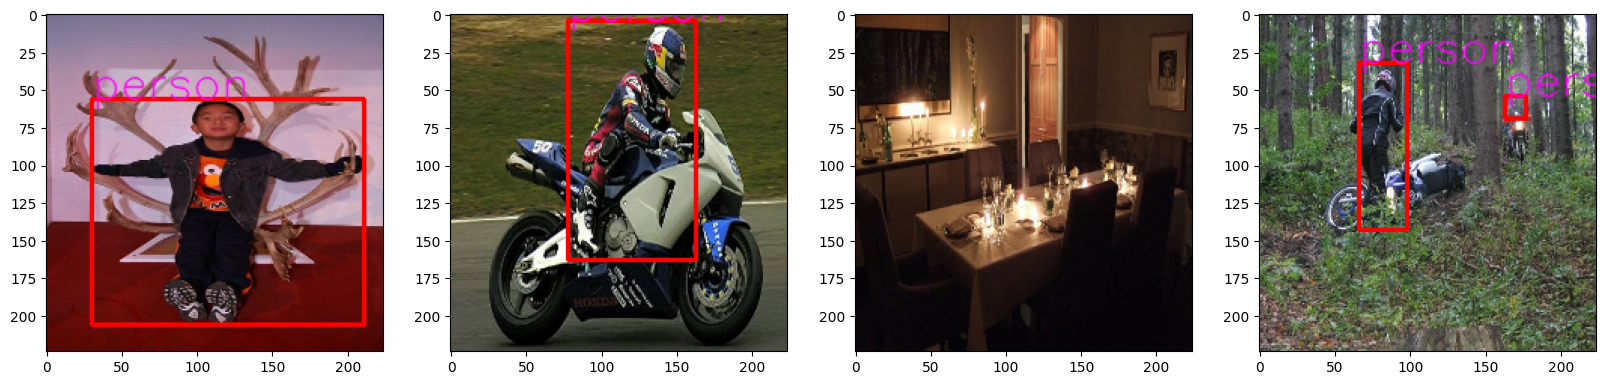

In [18]:
plt.figure()
confidence_thresh = 0.1
grid_width = 1 / 7
grid_dimen = np.array([224 * grid_width, 224 * grid_width]).astype(np.int32)
list_classes = ['not person', 'person']
plots = 4
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx] * 255).astype(np.uint8)
    

    for i in range(7) :
        for j in range(7) :
            class_idx = int(res[1][idx, i, j, :2].argmax())
            if res[1][idx, i, j, 6] < confidence_thresh or class_idx != 1: continue 
            sample_coords = res[1][idx,i, j, 2:6] #[x, y, w, h]
            grid_width = 1/7
            
            #width = sample_coords[2] * grid_dimen[0] 
            #height = sample_coords[3] * grid_dimen[1]
            width = sample_coords[2] * 224
            height = sample_coords[3] * 224
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[class_idx],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =1,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()

## YOLO model - Architecture
<img src = "images/yolo_v1_architecture.png"/>

### Defining a custom output layer
We need to reshape the output from the model so we define a custom Keras layer for it.

In [20]:
from tensorflow import keras
import keras.backend as K

class YoloActivation(tf.keras.layers.Layer) :
    
    def call(self, inputs) :
        classes = tf.nn.sigmoid(inputs[..., :2])
        coordinates = tf.sigmoid(inputs[..., 2:])
        return tf.concat([classes, coordinates], axis = -1)
    
        

### Building model

In [45]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, ResNet50

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=32
cell_h=32
img_w=grid_w*cell_w
img_h=grid_h*cell_h

featureExtractor = Sequential()
featureExtractor.add(
    VGG16(
        include_top=False, 
        weights = 'imagenet',
        input_shape =(img_h, img_w, 3)
    )
)

featureExtractor.trainable = False

model = Sequential()
model.add(featureExtractor)
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation = lrelu))
model.add(Dropout(0.5))
model.add(Dense(512, activation = lrelu))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(grid_w * grid_h * (2 + 5 * 1)))
model.add(Reshape((grid_w , grid_h , (2 + 5 * 1))))
model.add(YoloActivation())
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 343)               175959    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 7)           0         
                                                      

### Define a custom learning rate scheduler
The paper uses different learning rates for different epochs. So we define a custom Callback function for the learning rate.

In [18]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1e-1),
    (2, 1e-2),
    (10, 1e-3),
    (20, 1e-4),
    (50, 1e-5),
    (80, 1e-6),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

### Define the loss function
<img src = "images/loss_fn.png"/>

In [46]:
## YOLO LOSS
def yoloLoss(y_true, y_pred) :
    coordLoss = CoordLoss(y_true, y_pred)
    confidenceLoss = ConfidenceLoss(y_true, y_pred)
    classLoss = ClassLoss(y_true, y_pred)
    
    #return coordLoss
    return 25 * coordLoss + 15 * confidenceLoss + 5 * classLoss

def CoordLoss(y_true, y_pred) :
    #find if the object exists in the grid
    existsObject = tf.expand_dims(y_true[..., 6], -1)
    
    xy_pred = y_pred[..., 2:4]
    xy_true = y_true[..., 2:4]
    
    #wh_pred = existsObject * tf.math.sign(y_pred[..., 4:6]) * tf.sqrt(tf.math.abs(y_pred[..., 4:6]))
    #wh_true = existsObject * tf.sqrt(y_true[..., 4:6])
    
    wh_pred = y_pred[..., 4:6]
    wh_true = y_true[..., 4:6]
    
    coordLoss = tf.reduce_sum(tf.math.square(wh_pred - wh_true))
    coordLoss += tf.reduce_sum(tf.math.square(xy_pred - xy_true))
    
    return coordLoss / tf.cast(tf.math.count_nonzero(existsObject) , dtype = tf.float32) #for mean
    
    #delta_coord = tf.reduce_sum(tf.square(y_true[..., 2:4] - y_pred[..., 2:4]))
    
    #delta_size = tf.reduce_sum(tf.square(y_true[..., 4:6] - y_pred[..., 4:6]))
    
    #return delta_coord + delta_size
    

def ConfidenceLoss(y_true, y_pred):
    #find if the object exists in the grid
    existsObject = tf.expand_dims(y_true[..., 6], -1)
    
    #for object
    confidenceLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 6:7] - y_pred[..., 6:7])))
    
    #for no obejct
    confidenceLoss += 0.5 * tf.reduce_sum(tf.math.square((1 - existsObject) * (y_true[..., 6:7] - y_pred[..., 6:7])))
    
    return confidenceLoss / tf.cast(tf.math.count_nonzero(existsObject) , dtype = tf.float32) #for mean

def ClassLoss(y_true, y_pred) :
    #find if the object exists in the grid
    existsObject = tf.expand_dims(y_true[..., 6], -1)
     # Compute binary cross-entropy loss
    classLoss = tf.keras.losses.binary_crossentropy(tf.expand_dims(y_true[..., :2], -1), tf.expand_dims(y_pred[..., :2], -1))

    # Apply masking based on object existence
    classLoss = existsObject * existsObject

    # Compute the mean loss only for existing objects
    classLoss = tf.reduce_sum(classLoss) + 1e-4  # Adding a small epsilon to avoid division by zero
    return tf.cast(classLoss, dtype = tf.float32)
    #classLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., :2] - y_pred[..., :2])))
    
    #return classLoss / tf.cast(tf.math.count_nonzero(existsObject) , dtype = tf.float32) #for mean

def accuracy(y_true, y_pred) : 
    return tf.math.count_nonzero(tf.argmax(y_true[..., :2], axis=-1) == tf.argmax(y_pred[..., :2], axis=-1))

In [ ]:
yoloLoss(y_true=res[1], y_pred = res[1])

### Adding a callback for saving the weights

In [20]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight2_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

### Compile the model
Finally, compile the model using the custom loss function that was defined above.

In [21]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch
lr_decay # the drop in lr rate after each epoch

5.442176870748298e-05

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2, 
                               #decay=lr_decay
                              )
model.compile(opt, loss=yoloLoss, metrics = [CoordLoss, ConfidenceLoss, ClassLoss])

### Training the model

In [48]:
logdir = os.path.join('logs', '2 classes')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',)

hist = model.fit(x=train,
          #batch_size=batch_size,
          epochs = (10),
          verbose = 1,
          workers= 8,
          validation_data = val,
           callbacks=[
               tensorboard_callback,
               early_stopping_callback,
              #CustomLearningRateScheduler(lr_schedule),
              #mcp_save
          ])

Epoch 1/10
  378/12250 [..............................] - ETA: 54:34 - loss: 255.8499 - CoordLoss: 44.4882 - ConfidenceLoss: 8.7044 - ClassLoss: 8.0001


KeyboardInterrupt



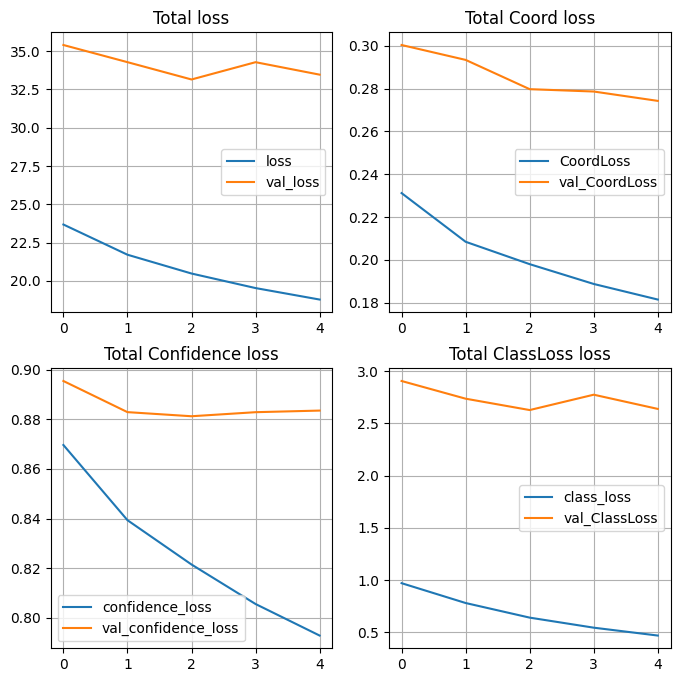

In [67]:
fig, ax = plt.subplots(ncols =2, nrows =2,  figsize= (8, 8))

ax[0][0].plot(hist.history['loss'], label = 'loss')
ax[0][0].plot(hist.history['val_loss'], label = 'val_loss')
ax[0][0].title.set_text('Total loss')
ax[0][0].grid(True)
ax[0][0].legend()

ax[0][1].plot(hist.history['CoordLoss'], label = 'CoordLoss')
ax[0][1].plot(hist.history['val_CoordLoss'], label = 'val_CoordLoss')
ax[0][1].title.set_text('Total Coord loss')
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(hist.history['ConfidenceLoss'], label = 'confidence_loss')
ax[1][0].plot(hist.history['val_ConfidenceLoss'], label = 'val_confidence_loss')
ax[1][0].title.set_text('Total Confidence loss')
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(hist.history['ClassLoss'], label = 'class_loss')
ax[1][1].plot(hist.history['val_ClassLoss'], label = 'val_ClassLoss')
ax[1][1].title.set_text('Total ClassLoss loss')
ax[1][1].grid(True)
ax[1][1].legend();

In [ ]:
model.save('facetracker.h5')
model.save_weights('facetracker_weights', save_format='tf')

In [27]:
model.load_weights('weight_4_classes_2.hdf5')

In [28]:
model.compile(opt, loss=yoloLoss, metrics = [CoordLoss, ConfidenceLoss, ClassLoss])

In [68]:
gen = test.as_numpy_iterator()

In [69]:
a = gen.next()

In [70]:
a[1].shape

(16, 7, 7, 7)

In [71]:
a[0].shape

(16, 224, 224, 3)

In [72]:
#model.compile(loss=yoloLoss ,optimizer='adam')
eval_ = model.predict(a[0])
eval_.shape

1/1 [==============================] - 0s 51ms/step


(16, 7, 7, 7)

In [73]:
res = (a[0], eval_)

<Figure size 640x480 with 0 Axes>

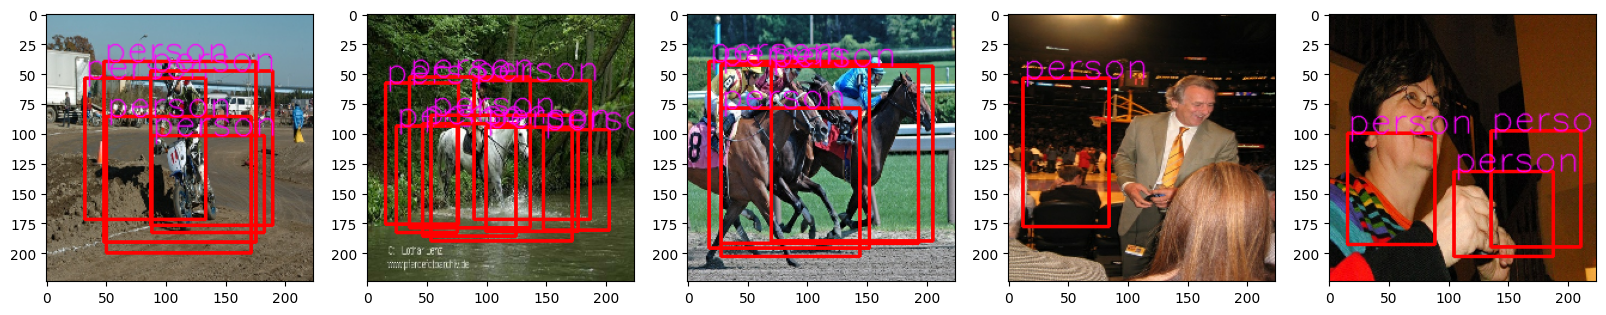

In [80]:
plt.figure()
start = 0
confidence_thresh = 0.05

grid_width = 1 / 7
grid_dimen = np.array([224 * grid_width, 224 * grid_width]).astype(np.int32)
list_classes = ['not person', 'person']
plots = 5
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx + start] * 255).astype(np.uint8)
    

    for i in range(7) :
        for j in range(7) :
            class_idx = int(res[1][idx + start, i, j, :2].argmax())
            if res[1][idx + start, i, j, 6] < confidence_thresh or class_idx != 1: continue 
            sample_coords = res[1][idx + start,i, j, 2:6] #[x, y, w, h]
            
            #width = sample_coords[2] * grid_dimen[0] 
            #height = sample_coords[3] * grid_dimen[1]
            width = sample_coords[2] * 224
            height = sample_coords[3] * 224
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[class_idx],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =1,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()